# Emissions and carbon price

In [1]:
import pandas as pd
import ixmp
import message_ix
import random
from message_ix.utils import make_df

%matplotlib inline

In [2]:
mp = ixmp.Platform()

In [3]:
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='gas_power_plant')
scen_b = base.clone(model, 'emission_bound','introducing bound on emissions and carbon price',
                  keep_solution=False)
scen_b.check_out()

In [4]:
year_df = scen_b.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen_b.set('year')
country = 'Westeros'

## Introducing Emissions

In [5]:
# first we introduce the emission of CO2 and the emission category GHG
scen_b.add_set('emission', 'CO2')
scen_b.add_cat('emission', 'GHG', 'CO2')

#we now add CO2 emissions to the coal powerplant
base_emission_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'tCO2/kWa',
}

emission_factor = make_df(base_emission_factor, technology= 'coal_ppl', emission= 'CO2', value = 7.4)
scen_b.add_par('emission_factor', emission_factor)

emission_factor = make_df(base_emission_factor, technology= 'gas_ppl', emission= 'CO2', value = 4.3)
scen_b.add_par('emission_factor', emission_factor)


Source of emission factor: "IPCC Working Group III – Mitigation of Climate Change, Annex III: Technology - specific cost and performance parameters - Table A.III.2 (Emissions of selected electricity supply technologies (gCO 2eq/kWh))" (PDF). IPCC. 2014. p. 1335. 

## Define a Bound on Emissions

The `type_year: cumulative` assigns an upper bound on the *weighted average of emissions* over the entire time horizon.

In [6]:
scen_b.add_par('bound_emission', [country, 'GHG', 'all', 'cumulative'],
             value=600., unit='MtCO2')

## Setting “sweet spot” prices on carbon

In [7]:
scen_b.add_set('type_year', [700, 710, 720])

base_tax_emission = {
    'node': 'Westeros',
    'type_year': [700, 710, 720],
    'type_tec': 'all',
    'unit': 'USD/tCO2',
    'type_emission': 'GHG',
    'value': random.randrange(1,18)
}

tax_emission = make_df(base_tax_emission)
scen_b.add_par('tax_emission', tax_emission)
scen_b.par('tax_emission')

,node,type_emission,type_tec,type_year,value,unit
0,Westeros,GHG,all,700,10.0,USD/tCO2
1,Westeros,GHG,all,710,10.0,USD/tCO2
2,Westeros,GHG,all,720,10.0,USD/tCO2


## Time to Solve the Model

In [8]:
scen_b.commit(comment='introducing emissions and carbon price')
scen_b.set_as_default()

In [9]:
scen_b.solve()

In [10]:
scen_b.var('OBJ')['lvl']

376452.8125

In [11]:
scen_b.var('EMISS', {'node': 'Westeros'})

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,471.137329,0.0
1,Westeros,CO2,all,710,711.135927,0.0
2,Westeros,CO2,all,720,617.726744,0.0


## Plotting Results

In [12]:
from tools import Plots
p = Plots(scen_b, country, firstyear=700)

### Activity

How much energy is generated in each time period from the different potential sources?

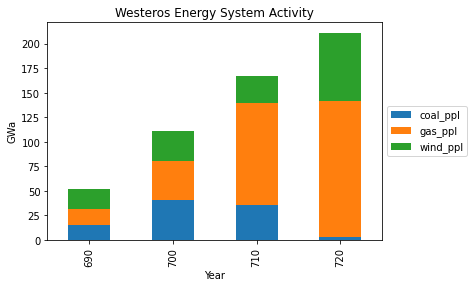

In [13]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'gas_ppl', 'wind_ppl'])

## Finding
A carbon price less than 18 USD/tCO2 represents the "sweet spot" where coal, wind and gas are used
at the same time, such that the gas power plant and wind dominate the energy mix thus reducing the share of coal power plant.

### Capacity

How much capacity of each plant is installed in each period?

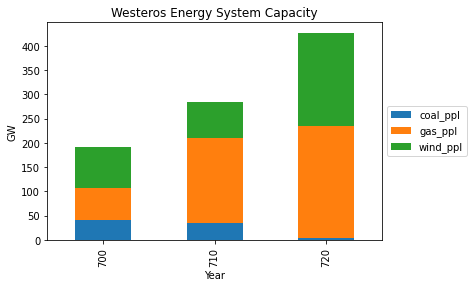

In [14]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'gas_ppl', 'wind_ppl'])

### Electricity Price

And how much does the electricity cost? These prices are in fact **shadow prices** taken from the **dual variables** of the model solution. They reflect the marginal cost of electricity generation (i.e., the additional cost of the system for supplying one more unit of electricity), which is in fact the marginal cost of the most expensive generator.  

Note the price drop when the most expensive technology is no longer in the system.

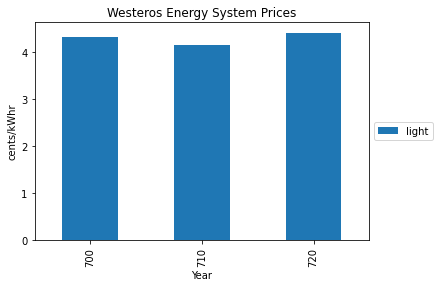

In [15]:
p.plot_prices(subset=['light'], baseyear=True)

## Close the connection to the database

In [16]:
mp.close_db()